# Tutorial 11: DeepWalk and node2vec - Implementation details
  

Paper:
* [DeepWalk: Online Learning of Social Representation](https://arxiv.org/pdf/1403.6652.pdf)  
* [node2vec: Scalable Feature Learning for Networks](https://arxiv.org/pdf/1607.00653.pdf)  

Code:

 * [node2vec doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=node2vec#torch_geometric.nn.models.Node2Vec)
 * [node2vec code](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/node2vec.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/node2vec.py)

In [1]:
%load_ext autoreload
%autoreload 2   

# Setup

# install on mac : pytorch_cluster
```
xcode-select --install
brew install cmake

export MACOSX_DEPLOYMENT_TARGET=12.0
export CC=clang
export CXX=clang++

git clone https://github.com/rusty1s/pytorch_cluster.git                                                                                        
cd pytorch_cluster
python setup.py install

pip install torch-cluster   # not poetry add.
```

In [2]:
from torch_geometric.nn import Node2Vec
import os.path as osp
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

In [3]:
dataset = "Cora"
path = osp.join(".", "data", dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,  # lenght of rw
    context_size=10,
    walks_per_node=20,
    num_negative_samples=1,
    p=200,
    q=1,  # bias parameters
    sparse=True,
).to(device)

# Random walks

### The data loader

In [5]:
loader = model.loader(batch_size=128, shuffle=True)

In [6]:
next(iter(loader))

(tensor([[ 110,  567,  536,  ..., 1262, 1509, 1262],
         [1630, 1269,  890,  ...,  514, 1314,  514],
         [ 290,  687, 1171,  ..., 2501, 1106, 1092],
         ...,
         [2517, 2516, 2517,  ..., 2516,  801, 1470],
         [1952, 1031,   48,  ..., 1666,   48, 1666],
         [ 611, 2690,  611,  ..., 2690,  611, 2690]]),
 tensor([[ 110, 2272, 1853,  ..., 1142,  575,  673],
         [1630, 2078, 2416,  ..., 1455,  173, 1467],
         [ 290,  548,  499,  ...,  430, 1038, 2106],
         ...,
         [1082, 1083, 1963,  ...,  945, 1617, 2326],
         [2600, 1037, 2436,  ...,  608, 2247, 2382],
         [2348, 1576, 2330,  ..., 1510, 2643, 2135]]))

In [7]:
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([28160, 10]) torch.Size([28160, 10])
1 torch.Size([28160, 10]) torch.Size([28160, 10])
2 torch.Size([28160, 10]) torch.Size([28160, 10])
3 torch.Size([28160, 10]) torch.Size([28160, 10])
4 torch.Size([28160, 10]) torch.Size([28160, 10])
5 torch.Size([28160, 10]) torch.Size([28160, 10])
6 torch.Size([28160, 10]) torch.Size([28160, 10])
7 torch.Size([28160, 10]) torch.Size([28160, 10])
8 torch.Size([28160, 10]) torch.Size([28160, 10])
9 torch.Size([28160, 10]) torch.Size([28160, 10])
10 torch.Size([28160, 10]) torch.Size([28160, 10])
11 torch.Size([28160, 10]) torch.Size([28160, 10])
12 torch.Size([28160, 10]) torch.Size([28160, 10])
13 torch.Size([28160, 10]) torch.Size([28160, 10])
14 torch.Size([28160, 10]) torch.Size([28160, 10])
15 torch.Size([28160, 10]) torch.Size([28160, 10])
16 torch.Size([28160, 10]) torch.Size([28160, 10])
17 torch.Size([28160, 10]) torch.Size([28160, 10])
18 torch.Size([28160, 10]) torch.Size([28160, 10])
19 torch.Size([28160, 10]) torch.Size([28

In [8]:
idx, (pos_rw, neg_rw) = next(enumerate(loader))

In [9]:
idx

0

In [10]:
(pos_rw.shape, neg_rw.shape)

(torch.Size([28160, 10]), torch.Size([28160, 10]))

In [11]:
pos_rw

tensor([[ 116, 1076,  116,  ..., 1076,  116, 1076],
        [ 553, 2009,  553,  ...,  297, 1542,  402],
        [1792,  581,  454,  ..., 1917,  454, 2022],
        ...,
        [ 848,  985, 1358,  ...,   88, 1847,  415],
        [1428, 1202, 1428,  ...,  911,   33, 2121],
        [ 488, 2547,  488,  ..., 1795, 1796, 2297]])

In [12]:
neg_rw

tensor([[ 116, 1270,  814,  ..., 1062, 1170, 1238],
        [ 553,  716, 1939,  ..., 1827, 1934, 1257],
        [1792, 1904,  465,  ..., 2240, 2676, 2147],
        ...,
        [1026,  394,  558,  ..., 2128, 1775, 1683],
        [ 677, 2524,  908,  ..., 1441, 2612, 2324],
        [1024,  249, 1318,  ...,  412, 2160,   51]])

### Visualization

In [13]:
import networkx as nx

edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, "pos")

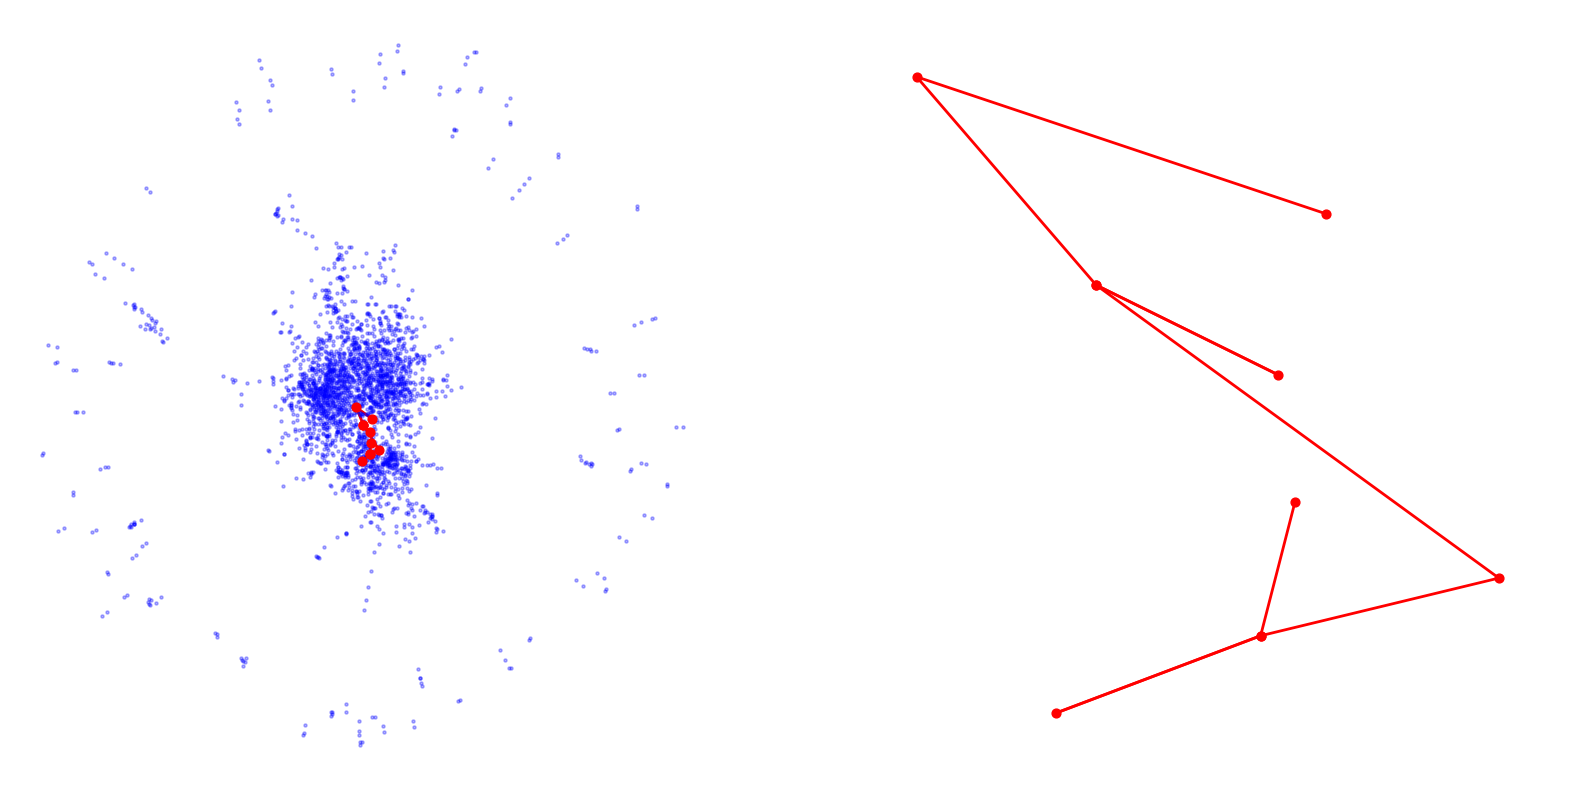

In [14]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(
    walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, "pos"
)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(
    G,
    ax=ax,
    pos=nx.get_node_attributes(G, "pos"),
    node_size=5,
    alpha=0.3,
    node_color="b",
)
nx.draw(
    walk,
    node_size=40,
    node_color="r",
    ax=ax,
    pos=nx.get_node_attributes(walk, "pos"),
    width=2,
    edge_color="r",
)
ax = fig.add_subplot(1, 2, 2)
nx.draw(
    walk,
    node_size=40,
    node_color="r",
    ax=ax,
    pos=nx.get_node_attributes(walk, "pos"),
    width=2,
    edge_color="r",
)

# Training

### Model definition

In [15]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

### Training function

In [16]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

### Test function

In [17]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [18]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [19]:
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [20]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        z[data.train_mask],
        data.y[data.train_mask],
        z[data.test_mask],
        data.y[data.test_mask],
        max_iter=150,
    )
    return acc

### Training

In [21]:
for epoch in range(1, 201):
    loss = train()
    acc = test()
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}")

  0%|          | 0/22 [00:00<?, ?it/s]

TypeError: cannot pickle 'PyCapsule' object

### Visualization

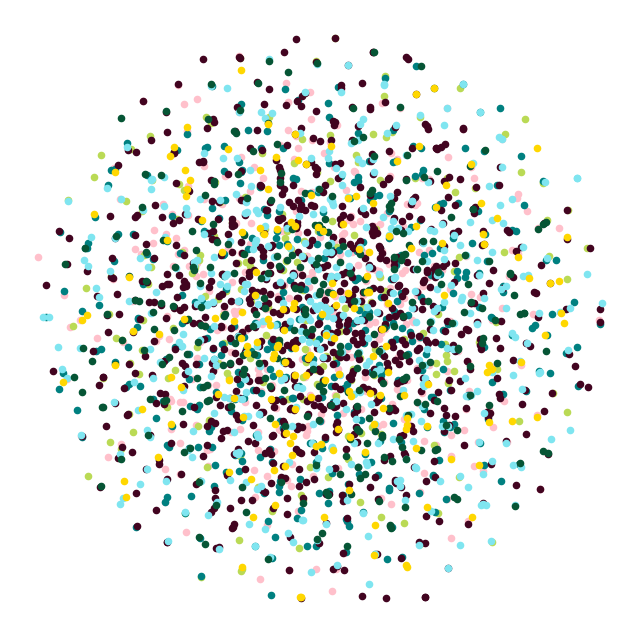

In [53]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis("off")
    plt.show()


colors = ["#ffc0cb", "#bada55", "#008080", "#420420", "#7fe5f0", "#065535", "#ffd700"]
plot_points(colors)